# Results Validation

This notebook includes a workflow to repeat the primary analysis using an 
independent dataset to validate those results. Since the primary analysis leverages
a reanalysis dataset, here we look to a satellite-derived dataset 
([NASA CERES EBAF](https://ceres.larc.nasa.gov/data/), version 4.1). 
The validation is visualized roughly here, reserving publication quality
visualization for a separate notebook.

## Preliminaries

### Requirements

* A Google Cloud project with Cloud Storage enabled ([Create new account](https://cloud.google.com/))
* Python packages. See `environments` directory for platform and notebook specific environment files.

### Imports

In [1]:
import utils

utils.check_environment("validate")

import glob
import logging
import os
import urllib.request

import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import colors
import numpy as np
import xarray as xr
import xesmf as xe

### Setup

In [2]:
# Logging configuration
logging.basicConfig(filename="validate.log", filemode="w", level=logging.INFO)

# Project ID
url = "http://metadata.google.internal/computeMetadata/v1/project/project-id"
req = urllib.request.Request(url)
req.add_header("Metadata-Flavor", "Google")
project_id = urllib.request.urlopen(req).read().decode()

## Functions

In [3]:
def weight_monthlymeans_by_daysinmonth(data):
    """Create annual-means weighing monthly-mean data by days in month.
    
    Args:
        data: xarray Dataset with monthly-mean time-indexed data.
    
    Returns:
        Annual-means computed from monthly-means weighted by the number of days in each month.
    """
    month_length = data.time.dt.days_in_month
    weights = (month_length.groupby("time.year") /
               month_length.groupby("time.year").sum())
    np.testing.assert_allclose(weights.groupby("time.year").sum().values, 
                               np.ones(len(np.unique(data.time.dt.year))))
    return (data * weights).groupby("time.year").sum(dim="time")


def cleanup_files(path, file_ext):
    """Remove files with a given file extension from a specified directory."""
    for i in glob.glob(os.path.join(path, f'*.{file_ext}')):
        os.remove(i)

## Workflow

First download the CERES data that Reflective Earth has placed in a Google Cloud Storage bucket:

In [4]:
utils.get_data_gcs("CERES_EBAF_Ed4.1_Subset_200101-202012.nc",
                   "ceres-ebaf-v410", user_project=project_id)

Next, organize the data coordinates to match ERA5, -180 to 180, -90 to 90

In [5]:
data = xr.open_dataset("CERES_EBAF_Ed4.1_Subset_200101-202012.nc")
data = data.assign_coords(lon=(((data.lon + 180) % 360) - 180))
data = data.sortby(data.lon, ascending=True)

In [6]:
data

<xarray.Dataset>
Dimensions:                (lon: 360, lat: 180, time: 240)
Coordinates:
  * lon                    (lon) float32 -179.5 -178.5 -177.5 ... 178.5 179.5
  * lat                    (lat) float32 -89.5 -88.5 -87.5 ... 87.5 88.5 89.5
  * time                   (time) datetime64[ns] 2001-01-15 ... 2020-12-15
Data variables: (12/13)
    toa_sw_all_mon         (time, lat, lon) float32 ...
    toa_sw_clr_c_mon       (time, lat, lon) float32 ...
    toa_sw_clr_t_mon       (time, lat, lon) float32 ...
    solar_mon              (time, lat, lon) float32 ...
    sfc_sw_down_all_mon    (time, lat, lon) float32 ...
    sfc_sw_down_clr_c_mon  (time, lat, lon) float32 ...
    ...                     ...
    sfc_sw_up_all_mon      (time, lat, lon) float32 ...
    sfc_sw_up_clr_c_mon    (time, lat, lon) float32 ...
    sfc_sw_up_clr_t_mon    (time, lat, lon) float32 ...
    sfc_net_sw_all_mon     (time, lat, lon) float32 ...
    sfc_net_sw_clr_c_mon   (time, lat, lon) float32 ...
    sfc_net_sw_clr_t_mon   (time, lat, lon) float32 ...
Attributes:
    title:        CERES EBAF TOA and Surface Fluxes. Monthly Averages and 07/...
    institution:  NASA Langley Research Center
    Conventions:  CF-1.4
    comment:      Climatology from 07/2005 to 06/2015
    version:      Edition 4.1; Release Date June 8, 2021
    DOI:          10.5067/TERRA-AQUA/CERES/EBAF_L3B004.1

Drop unnecessary variables from the dataset:

In [7]:
data = data.drop(["toa_sw_clr_c_mon", "toa_sw_clr_t_mon", 
                  "sfc_sw_down_clr_c_mon", "sfc_sw_down_clr_t_mon",
                  "sfc_sw_up_clr_c_mon", "sfc_sw_up_clr_t_mon", 
                  "sfc_net_sw_all_mon", "sfc_net_sw_clr_c_mon",
                  "sfc_net_sw_clr_t_mon"])

Rename the variables according to the pattern used in the primary data analysis:

In [8]:
data = data.rename({"toa_sw_all_mon": "tosr",
                    "solar_mon": "tisr",
                    "sfc_sw_down_all_mon": "ssrd",
                    "sfc_sw_up_all_mon": "ssru"})

Weight the monthly-mean data by the number of days in the month (see Function section above):

In [9]:
data_weighted = weight_monthlymeans_by_daysinmonth(data)

Rename the data dimensions to accurately represent annual-means and long name coordinates:

In [10]:
data_weighted = data_weighted.rename({"year": "time",
                                      "lat": "latitude",
                                      "lon": "longitude"})

Add attributes:

In [11]:
data_weighted["tosr"].attrs = {"long_name": "TOA outgoing solar radiation",
                               "standard_name": "toa_outgoing_shortwave_flux",
                               "units": "W m-2"}
data_weighted["tisr"].attrs = {"long_name": "TOA incoming solar radiation",
                               "standard_name": "toa_incoming_shortwave_flux",
                               "units": "W m-2"}
data_weighted["ssrd"].attrs = {"long_name": "Surface downwelling solar radiation",
                               "standard_name": "surface_downwelling_shortwave_flux",
                               "units": "W m-2"}
data_weighted["ssru"].attrs = {"long_name": "Surface upwelling solar radiation",
                               "standard_name": "surface_upwelling_shortwave_flux",
                               "units": "W m-2"}
data_weighted["time"].attrs = {"long_name": "Year"}

In [12]:
data_weighted

<xarray.Dataset>
Dimensions:    (longitude: 360, latitude: 180, time: 20)
Coordinates:
  * longitude  (longitude) float32 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * latitude   (latitude) float32 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * time       (time) int64 2001 2002 2003 2004 2005 ... 2017 2018 2019 2020
Data variables:
    tosr       (time, latitude, longitude) float64 123.2 123.2 ... 100.4 100.4
    tisr       (time, latitude, longitude) float64 172.2 172.2 ... 172.0 172.0
    ssrd       (time, latitude, longitude) float64 126.4 126.4 ... 98.65 98.65
    ssru       (time, latitude, longitude) float64 102.3 102.3 ... 64.7 64.7

Run the annual-means through the radiative transfer model described in the primary data analysis:

In [13]:
data_weighted = utils.compute_radiative_properties(data_weighted)

In [14]:
data_weighted

<xarray.Dataset>
Dimensions:    (longitude: 360, latitude: 180, time: 20)
Coordinates:
  * longitude  (longitude) float32 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * latitude   (latitude) float32 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * time       (time) int64 2001 2002 2003 2004 2005 ... 2017 2018 2019 2020
Data variables: (12/13)
    tosr       (time, latitude, longitude) float64 123.2 123.2 ... 100.4 100.4
    tisr       (time, latitude, longitude) float64 172.2 172.2 ... 172.0 172.0
    ssrd       (time, latitude, longitude) float64 126.4 126.4 ... 98.65 98.65
    ssru       (time, latitude, longitude) float64 102.3 102.3 ... 64.7 64.7
    R          (time, latitude, longitude) float64 0.7153 0.7153 ... 0.5837
    T          (time, latitude, longitude) float64 0.7341 0.7341 ... 0.5736
    ...         ...
    alpha      (time, latitude, longitude) float64 0.8094 0.8094 ... 0.6558
    a          (time, latitude, longitude) float64 0.1448 0.1448 ... 0.2189
    r          (time, latitude, longitude) float64 0.3287 0.3287 ... 0.3132
    t          (time, latitude, longitude) float64 0.5265 0.5265 ... 0.4679
    srosr      (time, latitude, longitude) float64 66.58 66.58 ... 46.52 46.52
    psrosr     (time, latitude, longitude) float64 65.05 65.05 ... 47.39 47.39

Average the annual-means into a long-term mean 2001 through 2020:

In [15]:
rom_ceres = data_weighted.mean(dim="time")

Save the long-term mean to the assets directory:

In [16]:
rom_ceres.to_netcdf("rom_analysis_ceres.nc")

In [17]:
utils.put_data_gcs(file_name="rom_analysis_ceres.nc",
                   bucket_name="rom-input", user_project=project_id)

In [18]:
rom_ceres

<xarray.Dataset>
Dimensions:    (longitude: 360, latitude: 180)
Coordinates:
  * longitude  (longitude) float32 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * latitude   (latitude) float32 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
Data variables: (12/13)
    tosr       (latitude, longitude) float64 122.4 122.4 122.4 ... 104.3 104.3
    tisr       (latitude, longitude) float64 172.4 172.4 172.4 ... 172.3 172.3
    ssrd       (latitude, longitude) float64 127.2 127.2 127.2 ... 99.13 99.13
    ssru       (latitude, longitude) float64 102.2 102.2 102.2 ... 69.97 69.97
    R          (latitude, longitude) float64 0.7099 0.7099 ... 0.6049 0.6049
    T          (latitude, longitude) float64 0.7379 0.7379 ... 0.5752 0.5752
    ...         ...
    alpha      (latitude, longitude) float64 0.8039 0.8039 ... 0.7058 0.7058
    a          (latitude, longitude) float64 0.1453 0.1453 ... 0.2259 0.2259
    r          (latitude, longitude) float64 0.3171 0.3171 ... 0.3267 0.3267
    t          (latitude, longitude) float64 0.5376 0.5376 ... 0.4474 0.4474
    srosr      (latitude, longitude) float64 67.71 67.71 67.71 ... 47.96 47.96
    psrosr     (latitude, longitude) float64 66.86 66.86 66.86 ... 44.87 44.87

ERA5 and CERES EBAF have different spatial resolution. In order to compare them,
we must regrid one of the products to the same grid as the other. Here we choose
to coarsen ERA5 to the 1° CERES EBAF resolution. Keep in mind that we are using the
ERA5 averages over the CERES EBAF overlap period 2001 through 2020.

In [19]:
utils.get_data_gcs(file_name="rom_analysis_ceres_overlap.nc", 
                   bucket_name="rom-input", user_project=project_id)

In [20]:
rom_era5 = xr.open_dataset("rom_analysis_ceres_overlap.nc")
rom_era5 = rom_era5.assign_coords(longitude=(((rom_era5.longitude + 180) % 360) - 180))
rom_era5 = rom_era5.sortby(rom_era5.longitude, ascending=True)

The latitude and longitude dimensions must be renamed to work with the xESMF
regridder.

In [21]:
rom_era5 = rom_era5.rename_dims({"latitude": "lat",
                                 "longitude": "lon"}).rename_vars({"latitude": "lat",
                                                                   "longitude": "lon"})
rom_ceres = rom_ceres.rename_dims({"latitude": "lat",
                                 "longitude": "lon"}).rename_vars({"latitude": "lat",
                                                                   "longitude": "lon"})

We use a bilinear regridding scheme from [xESMF](https://xesmf.readthedocs.io/en/latest/).

In [22]:
regridder = xe.Regridder(rom_era5, rom_ceres, "bilinear", 
                         periodic=True, reuse_weights=False)
rom_era5_coarse = regridder(rom_era5)

/opt/conda/envs/validate/lib/python3.8/site-packages/xesmf/smm.py:130: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')
/opt/conda/envs/validate/lib/python3.8/site-packages/xesmf/smm.py:130: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')


In [23]:
rom_era5_coarse.to_netcdf("rom_analysis_coarse.nc")

In [24]:
utils.put_data_gcs(file_name="rom_analysis_coarse.nc",
                   bucket_name="rom-input", user_project=project_id)

## Discussion

### Radiative properties from simple model of reflected radiation

#### 1-layer atmosphere transmissivity

Transmissivity varies between 30 and 80%, and CERES EBAF and ERA5 compare to
within 5-10% generally and diverge ±20% at most. CERES EBAF-based 
transmittance is higher over the subtropical oceans and Arctic Ocean, 
whereas ERA5 based transmittance is higher over the Southern Ocean and 
off the west coasts of North America, South America, and Africa.

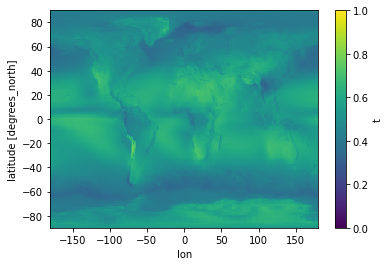

In [25]:
rom_ceres.t.plot.imshow(vmin=0, vmax=1)

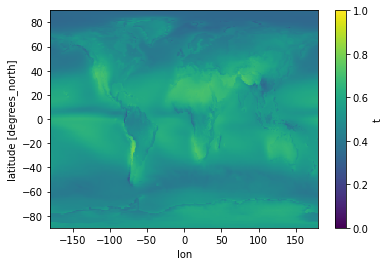

In [26]:
rom_era5_coarse.t.plot.imshow(vmin=0, vmax=1)

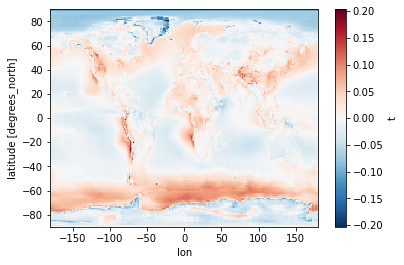

In [27]:
(rom_era5_coarse - rom_ceres).t.plot.imshow()

#### 1-layer atmosphere absorption

Annual-mean atmospheric absorptance varies from 12 to 30%, ERA5 and CERES
EBAF-based results compare to wihtin a few percent generally and diverge 
by ±6% at most. ERA5-based atmospheric absorptance is higher over the 
polar regions as well as over the global desert regions. Conversely, 
CERES EBAF-based atmospheric absorptance is higher over the tropical 
forest regions of South America, Africa, and Asia.

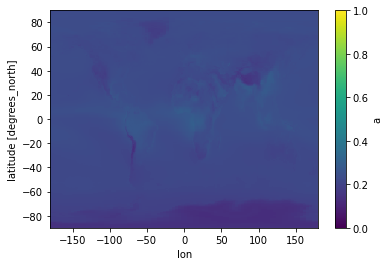

In [28]:
rom_ceres.a.plot.imshow(vmin=0, vmax=1)

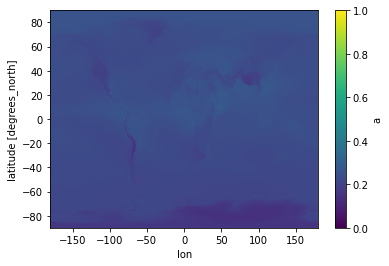

In [29]:
rom_era5_coarse.a.plot.imshow(vmin=0, vmax=1)

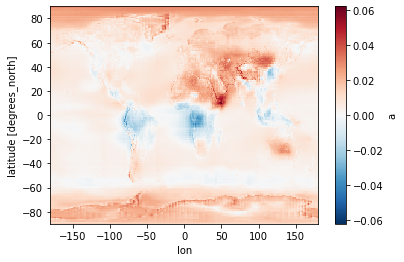

In [30]:
(rom_era5_coarse - rom_ceres).a.plot.imshow()

#### 1-layer atmosphere reflectivity

Annual-mean atmospheric reflectivity varies from 6 to 47%, and ERA5 and CERES EBAF-based results agree to within 5% generally, and up to about ±15%. Reflectivity based on CERES EBAF is higher over land and notably over parts of the ocean with stratocumulus: off the subtropical west coasts of continents and the Southern Ocean. CERES EBAF-based atmospheric reflectivity is lower than ERA5-based results over the subtropical ocean gyres and over the Arctic Ocean.

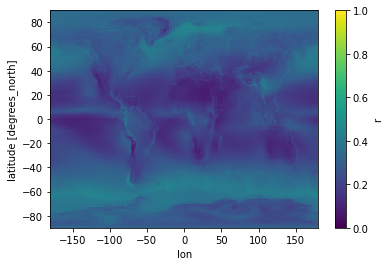

In [31]:
rom_ceres.r.plot.imshow(vmin=0, vmax=1)

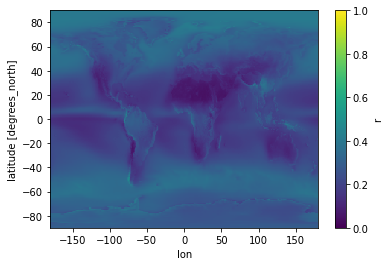

In [32]:
rom_era5_coarse.r.plot.imshow(vmin=0, vmax=1)

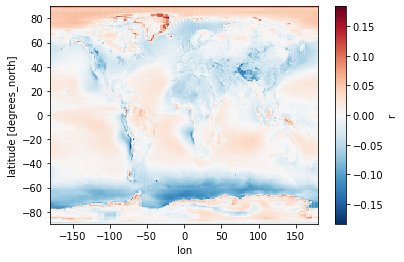

In [33]:
(rom_era5_coarse - rom_ceres).r.plot.imshow()

### Radiative properties from the input data

#### Surface albedo

Surface albedo generally agree to within a few percent between CERES EBAF
and ERA5. Notable exceptions include the Greenland Ice Sheet, the 
Himalayan Plateau, the Southern Andes, and the Coast Range of Alaska. 
This suggests differences where snow, ice, and rock exist near each other.
Small differences are also evident over the Southern Ocean–suggestive of 
sea-ice differences–and Antarctica.

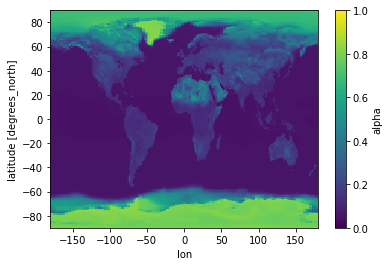

In [34]:
rom_ceres.alpha.plot.imshow(vmin=0, vmax=1, cmap="viridis")

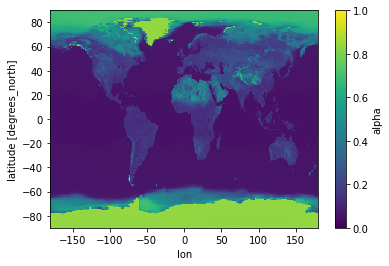

In [35]:
rom_era5_coarse.alpha.plot.imshow(vmin=0, vmax=1, cmap="viridis")

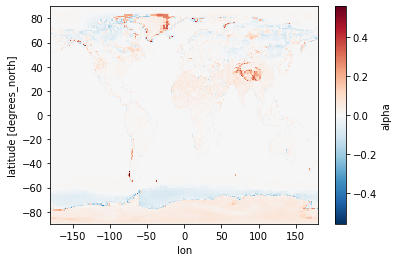

In [36]:
(rom_era5_coarse - rom_ceres).alpha.plot.imshow()

### Radiative fluxes

#### Incoming solar radiation at top of atmosphere

There are exceedingly small differences between the two datasets in terms of
incoming solar radiation. This may be caused by the interpolation of ERA5 
to the CERES EBAF grid.

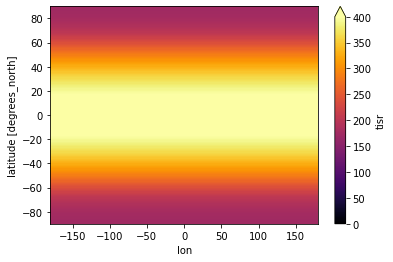

In [37]:
rom_ceres.tisr.plot.imshow(vmin=0, vmax=400, cmap="inferno")

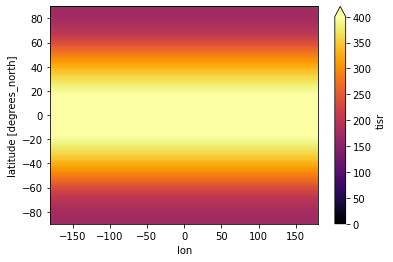

In [38]:
rom_era5_coarse.tisr.plot.imshow(vmin=0, vmax=400, cmap="inferno")

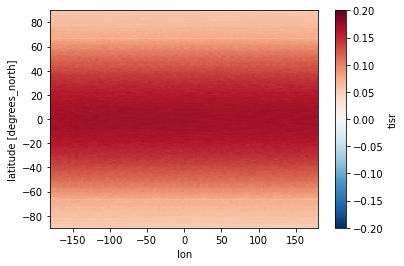

In [39]:
(rom_era5_coarse - rom_ceres).tisr.plot.imshow(vmin=-0.2, vmax=0.2, cmap="RdBu_r")

#### Atmosphere-reflected solar radiation

This pattern essentially a latitudinally damped version of the atmospheric
reflectivity difference pattern. CERES EBAF-based results have slightly 
more atmospheric reflected solar radiation over the Southern Ocean, land 
surface, and marine stratocumulus regions.

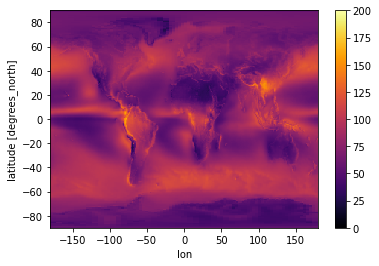

In [40]:
(rom_ceres.tisr * rom_ceres.r).plot.imshow(vmin=0, vmax=200, cmap="inferno")

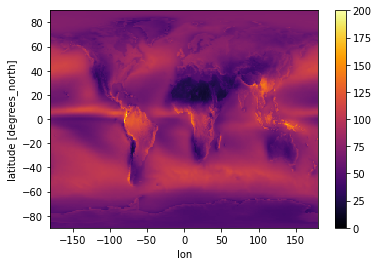

In [41]:
(rom_era5_coarse.tisr * rom_era5_coarse.r).plot.imshow(vmin=0, vmax=200, cmap="inferno")

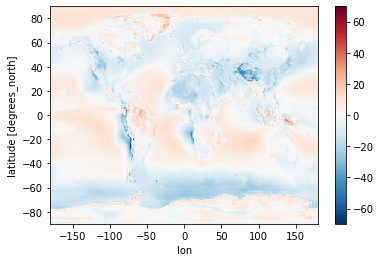

In [42]:
((rom_era5_coarse.tisr * rom_era5_coarse.r) -
 (rom_ceres.tisr * rom_ceres.r)).plot.imshow()

#### Planet-received incoming solar radiation

The radiation received at the surface has the inverse difference pattern 
as atmospheric reflected radiation. ERA5 is slightly higher over land and
across the Southern Ocean. CERES EBAF is slightly higher in the polar 
regions and across the subtropical ocean gyes.

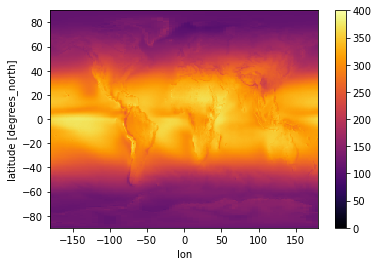

In [43]:
(rom_ceres.tisr - (rom_ceres.tisr * rom_ceres.r)).plot.imshow(vmin=0, vmax=400, cmap="inferno")

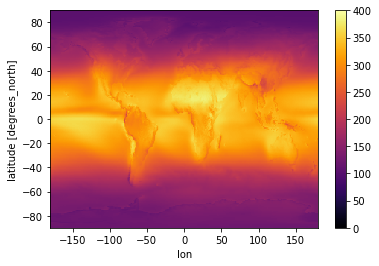

In [44]:
(rom_era5_coarse.tisr - (rom_era5_coarse.tisr * rom_era5_coarse.r)).plot.imshow(vmin=0, vmax=400, cmap="inferno")

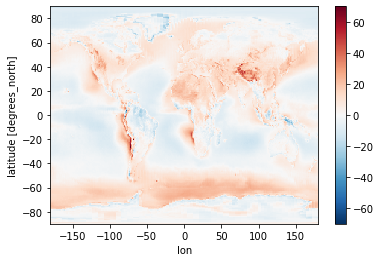

In [45]:
((rom_era5_coarse.tisr - (rom_era5_coarse.tisr * rom_era5_coarse.r)) -
 (rom_ceres.tisr - (rom_ceres.tisr * rom_ceres.r))).plot.imshow()

#### Potential surface-reflected outgoing solar radiation

Potential surface-reflected outgoing solar radiation is close to wihtin 
20 watts per square meter in general, and larger in some local areas. 
ERA5-based results are higher off the west coast of South America, North 
America, and Africa, as well as over land along the Rocky Mountains and the
Himalayan Plateau.

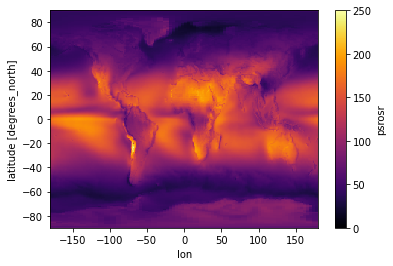

In [46]:
rom_ceres.psrosr.plot.imshow(vmin=0, vmax=250, cmap="inferno")

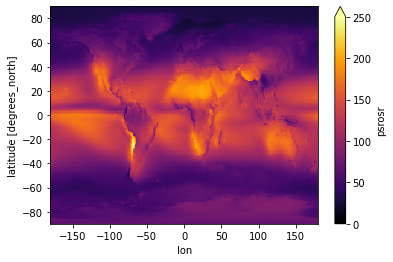

In [47]:
rom_era5_coarse.psrosr.plot.imshow(vmin=0, vmax=250, cmap="inferno")

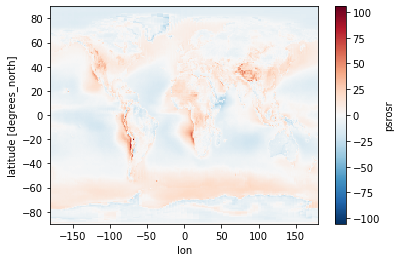

In [48]:
(rom_era5_coarse - rom_ceres).psrosr.plot.imshow()

#### Actual surface-reflected outgoing solar radiation

Actual surface-reflected outgoing solar radiation agrees very well between 
the two data products except for over the Southern Andes and the Himalayan 
Plateau. This is likely related to the surface albedo differences between 
the two datasets.

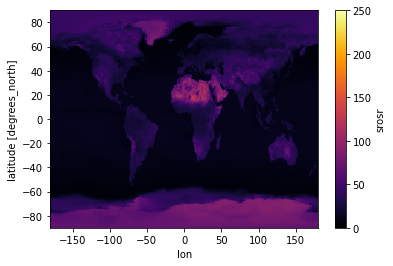

In [49]:
rom_ceres.srosr.plot.imshow(vmin=0, vmax=250, cmap="inferno")

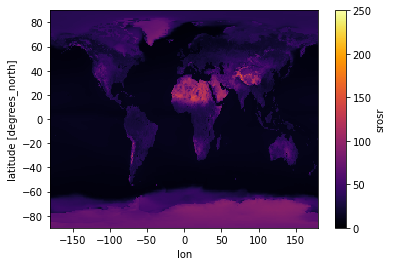

In [50]:
rom_era5_coarse.srosr.plot.imshow(vmin=0, vmax=250, cmap="inferno")

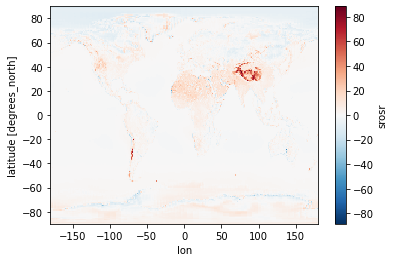

In [51]:
(rom_era5_coarse - rom_ceres).srosr.plot.imshow()

#### Potential gain in surface-reflected outgoing solar radiation

The unrealized gain in surface-relfected outgoing solar radiation is the 
difference between the potential and actual surface-reflected outgoing 
solar radiation. Differences between ERA5 and CERES EBAF-based results 
are greatest over the marine stratocumulus regions and to some extent 
over the subtropical ocean gyres. This pattern incorporates features 
from the atmospheric radiative properties shown earlier.

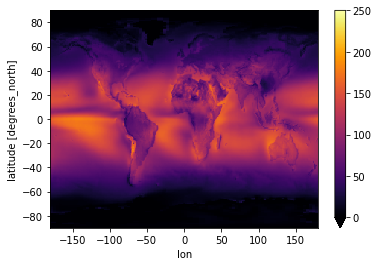

In [52]:
(rom_ceres.psrosr - rom_ceres.srosr).plot.imshow(vmin=0, vmax=250, cmap="inferno")

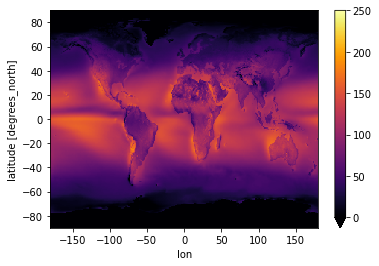

In [53]:
(rom_era5_coarse.psrosr - rom_era5_coarse.srosr).plot.imshow(vmin=0, vmax=250, cmap="inferno")

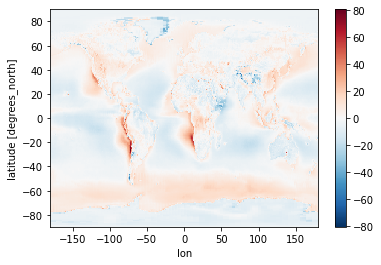

In [54]:
((rom_era5_coarse.psrosr - rom_era5_coarse.srosr) -
 (rom_ceres.psrosr - rom_ceres.srosr)).plot.imshow()

## Conclusion

Overall, these validation results support our primary data analysis. The CERES
EBAF-based results are very complementary to the ERA5-based results. There are
some differences, however they appear to be small for the most part. None of
the differences materially affect our conclusions regarding the areas with 
highest potential. At most, the differences between the two datasets offers 
an estimate of uncertainty for the radiative parameters we considered.

In [55]:
cleanup_files(path=".", file_ext="nc")